In [1]:
import os
import re
import sys
import json
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from datetime import datetime, timedelta

In [2]:
def fetch_all_pages(collection, query, batch_size=1000):
    base_url = "https://flowmaps.life.bsc.es/api"
    url = f"{base_url}/{collection}"
    params = {'where': json.dumps(query), 'max_results': batch_size}

    data = []
    response = requests.get(url, params=params).json() # get first page
    data.extend(response['_items'])
    if '_links' not in response:
        return data
    num_docs = response['_meta']['total']
    if num_docs <= 0:
        return data
    num_pages = int(num_docs/batch_size)
    while 'next' in response['_links']:
        url = f"{base_url}/{response['_links']['next']['href']}"
        response = requests.get(url).json()
        data.extend(response['_items'])
    return data


def daily_mobility_matrix(source_layer, target_layer, date):
    filters = {
        'date': date,
        'source_layer': source_layer,
        'target_layer': target_layer,
    }
    data = fetch_all_pages('mitma_mov.daily_mobility_matrix', filters)

    return pd.DataFrame(data)
    

def get_population(layer, date):
    filters = {
        'layer': layer,
        'type': 'population',
        '$gte': date, 
        '$lte': date
    }
    data = fetch_all_pages('layers.data.consolidated', filters)
    return pd.DataFrame(data)

In [4]:
data_folder = 'data'


# sns.color_palette()
# sns.set_theme(style="ticks")

reference_dates = ['2020-02-15', '2020-04-15', '2020-07-15', '2020-11-15']

source_layer = "cnig_ccaa"
target_layer = "cnig_ccaa"

date = reference_dates[0]


df_population = get_population(source_layer, date)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [3]:
source_layer = "cnig_ccaa"
target_layer = "cnig_ccaa"

start = '2020-02-14'
end = '2021-01-01'
data = []
for d in pd.date_range(start=start, end=end):
    date = d.strftime("%Y-%m-%d") 
    df_odm = daily_mobility_matrix(source_layer, target_layer, date)
    
    inter_ccaa = df_odm['trips'][ df_odm['source'] == df_odm['target'] ].sum()
    intra_ccaa = df_odm['trips'][ df_odm['source'] != df_odm['target'] ].sum()
    
    data.append((d, date, inter_ccaa, intra_ccaa))

In [4]:
df_trips = pd.DataFrame(data, columns=['date', 'sdate', 'intra', 'inter'])

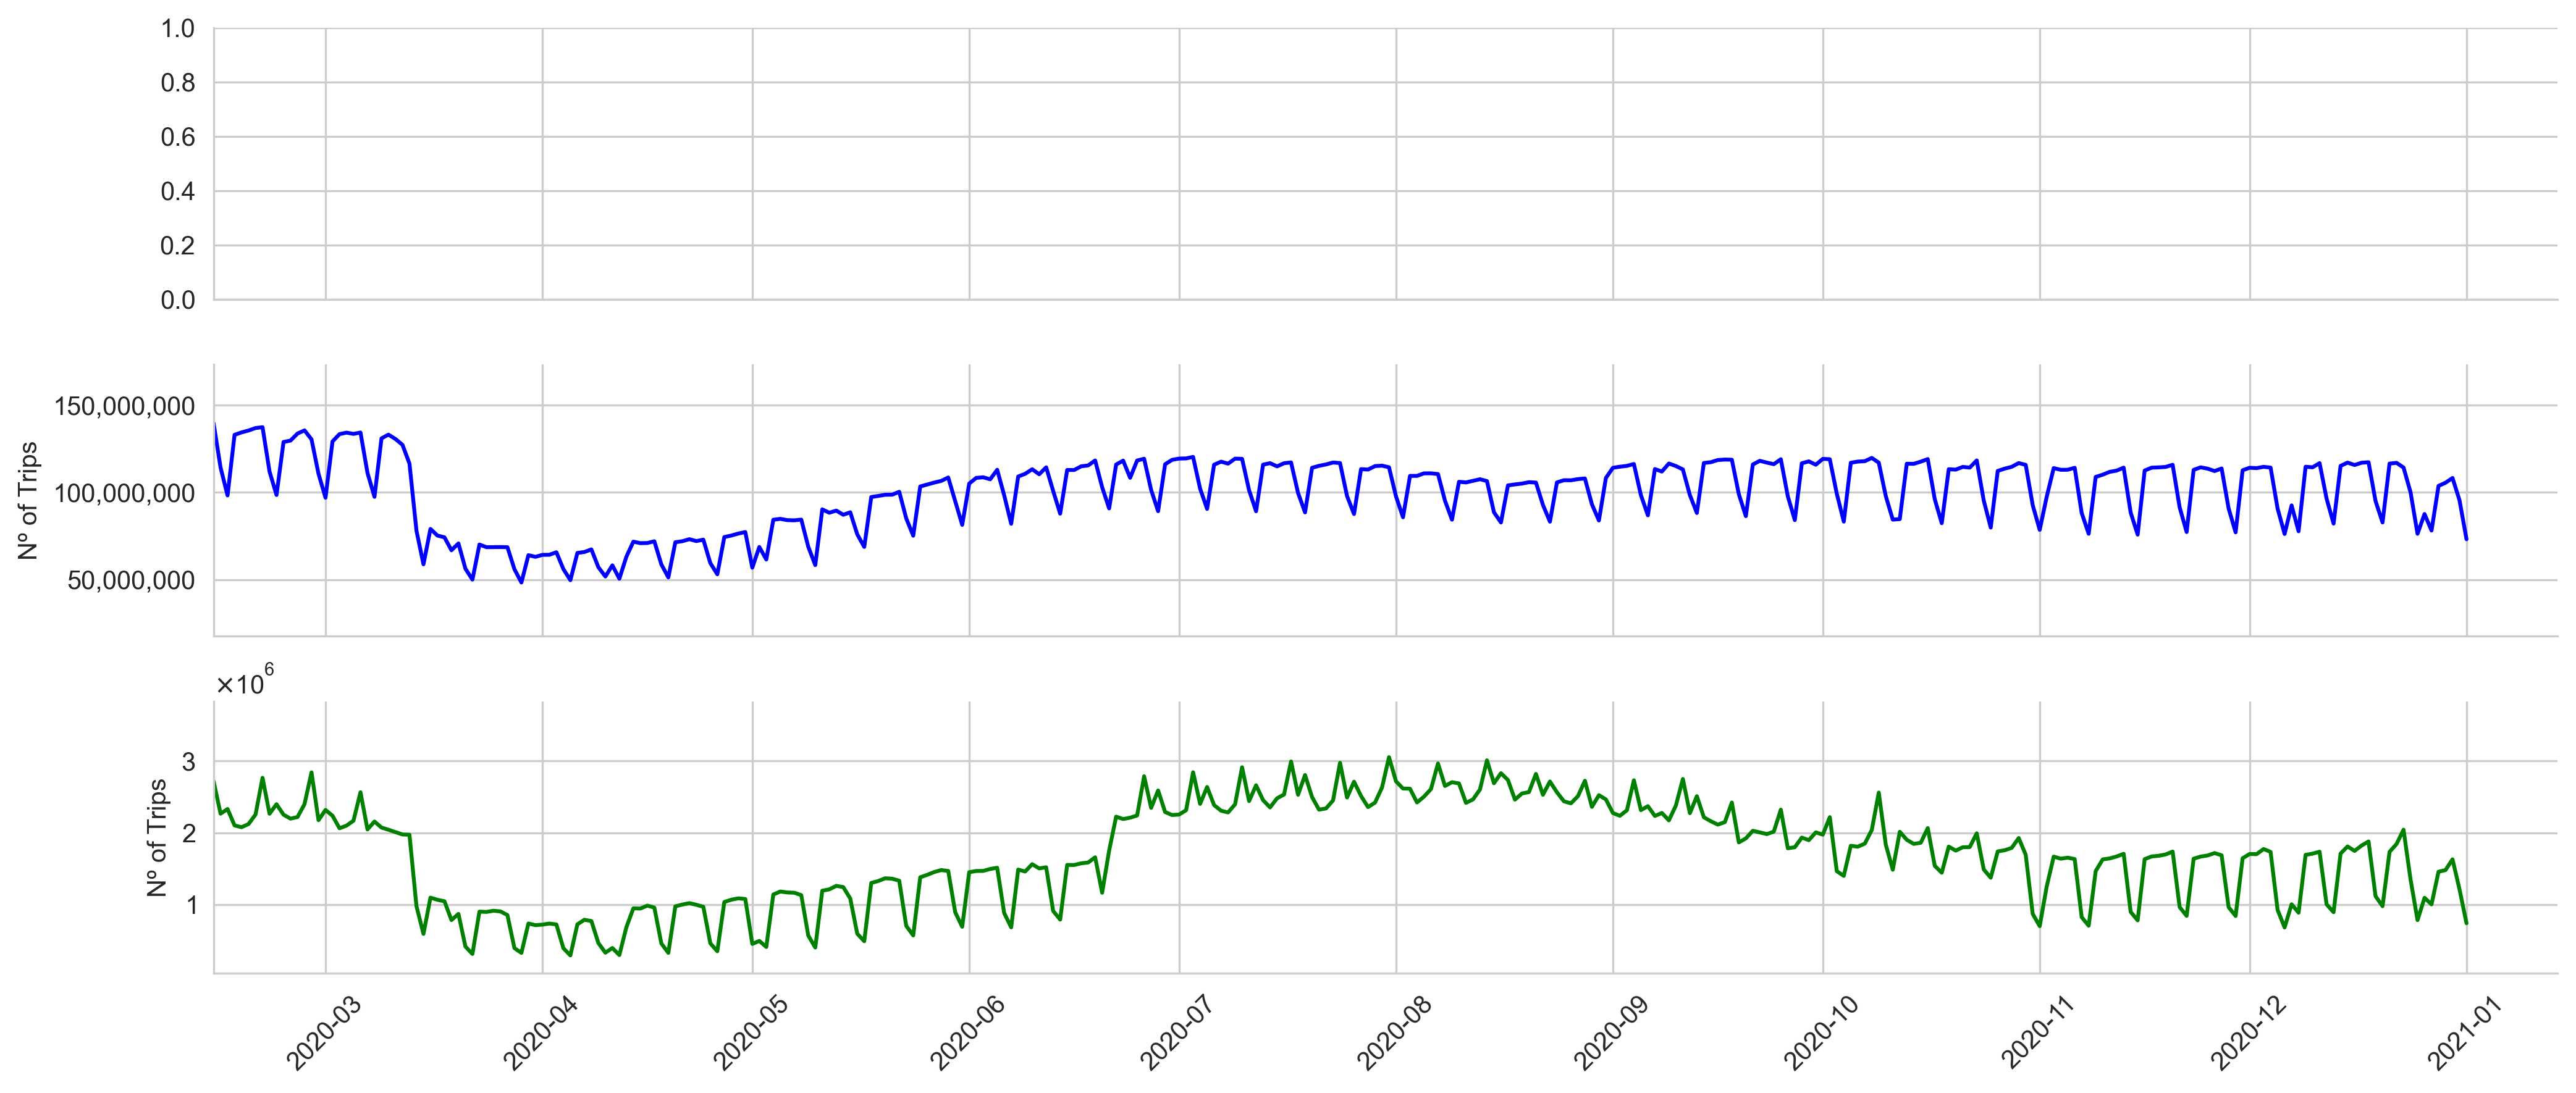

In [5]:
import datetime as dt
import matplotlib as mpl

sns.set_style("whitegrid")
fig, axes = plt.subplots(3,1, figsize=(14,6), sharex=True, dpi=300)

ax = axes[0]

x = df_trips.date
# y = df_population
# ax.plot(x, df_agg_mobility['moving'], c='r')
# ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
# mov_index = df_agg_mobility['moving']/df_agg_mobility.sum(axis=1)*100
# ax.plot(x, mov_index, c='r')

# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_ylim([30,80])
# ax.set_ylabel('Population')



# x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df.date]

x = df_trips.date
ax = axes[1]
y = df_trips.intra
ax.plot(x, y, c='b')
ax.ticklabel_format(axis='y', style='sci')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ymin, ymax = ax.get_ylim()
ax.set_ylim((ymin*0.4, ymax*1.2))
ax.set_ylabel('Nº of Trips')


ax = axes[2]
y = df_trips.inter
ax.plot(x, y, c='g')
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
ymin,ymax = ax.get_ylim()
ax.set_ylim((ymin*0.3, ymax*1.2))
ax.set_ylabel('Nº of Trips')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set(xlabel="", xlim=[x[0], dt.datetime.strptime("2021-01-14",'%Y-%m-%d').date()])

fig.autofmt_xdate(rotation=45, ha="center")
sns.despine(fig)
fig.tight_layout()

fig.savefig('../out/Figure_8.png')